# Two-layer hybrid recommender system in retail

**Data:** from [Retail X5 Hero Competition](https://retailhero.ai/c/recommender_system/overview)

**Stack:**

- 1-st layer: NLP, Implicit, ItemItemRecommender, ALS, sklearn, pandas, numpy, matplotlib
- 2-nd layer: CatBoost, LightGBM



**Stages**:

1. Prepare data:  prefiltering
2. Marching model (initialize MainRecommender 1-st layer model as baseline)
3. Evaluate Top@k Recall
4. Ranking model (choose 2-nd layer model)
5. Feature engineering for ranking
6. Validate on test.csv

# 1. Prepare data

Import necessary libs:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Second layer models
from lightgbm import LGBMClassifier
from catboost import CatBoost

# Functions for prefilter, evaluate and baseline
from src.utils import prefilter_items
from src.metrics import precision_at_k, recall_at_k
from src.recommenders import MainRecommender

# Ignore some warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/retail_train.csv')
test = pd.read_csv('data/retail_test.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

Let's look at data

In [5]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0


In [7]:
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [8]:
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88734 entries, 0 to 88733
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            88734 non-null  int64  
 1   basket_id          88734 non-null  int64  
 2   day                88734 non-null  int64  
 3   item_id            88734 non-null  int64  
 4   quantity           88734 non-null  int64  
 5   sales_value        88734 non-null  float64
 6   store_id           88734 non-null  int64  
 7   retail_disc        88734 non-null  float64
 8   trans_time         88734 non-null  int64  
 9   week_no            88734 non-null  int64  
 10  coupon_disc        88734 non-null  float64
 11  coupon_match_disc  88734 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 8.1 MB


In [28]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   item_id               92353 non-null  int64 
 1   manufacturer          92353 non-null  int64 
 2   department            92353 non-null  object
 3   brand                 92353 non-null  object
 4   commodity_desc        92353 non-null  object
 5   sub_commodity_desc    92353 non-null  object
 6   curr_size_of_product  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [29]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [20]:
def print_stats_data(df_data, name_df):
    print(f'{name_df}:')
    print(f"Shape: {df_data.shape} Users: {df_data['user_id'].nunique()} Items: {df_data['item_id'].nunique()}\n")

In [22]:
print_stats_data(data, 'data')
print_stats_data(test, 'test')

data:
Shape: (2396804, 12) Users: 2499 Items: 89051

test:
Shape: (88734, 12) Users: 1885 Items: 20497



Prepare columns feature datasets

In [12]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id' }, inplace=True)

### Split dataset for train, eval and test

In [17]:
# timeline for train:  -- old purchases -- | -- 6 weeks -- 

VAL_MATCHER_WEEKS = 6

In [23]:
# data for train 1-st layer model (matching)     -- old purchases --
data_train_matcher = data[data['week_no'] < data['week_no'].max() - VAL_MATCHER_WEEKS]

# data for validate 1-st layer model (matching)  -- 6 weeks --
data_val_matcher = data[data['week_no'] >= data['week_no'].max() - VAL_MATCHER_WEEKS]

# data for train 2-nd layer model (ranking)      -- 6 weeks --
data_train_ranker = data_val_matcher.copy()

# data for validate 2-nd layer model (ranking)   -- 3 weeks (test data) --
data_val_ranker = test.copy()

In [24]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher:
Shape: (2193515, 12) Users: 2499 Items: 85334

val_matcher:
Shape: (203289, 12) Users: 2197 Items: 30040

train_ranker:
Shape: (203289, 12) Users: 2197 Items: 30040

val_ranker:
Shape: (88734, 12) Users: 1885 Items: 20497



Here is dispertion of users and items. In this case we won't use "cold-start" and fix it below. But for "cold-start" may use top popular items as base case from baseline.

### Prefilter data_train_matcher

For begin we will take 5000 popular items. But later we try select better decision.

In [30]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 85334 to 5001


### Make "cold-start" to "warm-start"

In [31]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher:
Shape: (896610, 13) Users: 2496 Items: 5001

val_matcher:
Shape: (203235, 12) Users: 2194 Items: 30037

train_ranker:
Shape: (203235, 12) Users: 2194 Items: 30037

val_ranker:
Shape: (88665, 12) Users: 1883 Items: 20492



# 2. Initialize MainRecommender

In [32]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

# 3. Evaluate Top@k Recall

In [38]:
result_eval_matcher = data_val_matcher.groupby('user_id')['item_id'].unique().reset_index()
result_eval_matcher.columns=['user_id', 'actual']
result_eval_matcher.head(2)

,user_id,actual
0,1,"[829323, 835108, 836423, 851515, 875240, 87737..."
1,2,"[895388, 8357614, 12301772, 821083, 828106, 83..."


In [39]:
# N = Number recommendations
N_PREDICT = 50 

### Get recommendations

In [47]:
%%time

result_eval_matcher['own_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

result_eval_matcher['sim_item_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))

result_eval_matcher['als_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

result_eval_matcher['top_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.overall_top_purchases[:N_PREDICT])

CPU times: user 1min 20s, sys: 629 ms, total: 1min 21s
Wall time: 24.9 s


In [48]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,top_rec
0,1,"[829323, 835108, 836423, 851515, 875240, 87737...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9803207, 9297615, 888210, 10...","[1029272, 1047619, 909497, 1119942, 1088387, 9...","[1029743, 1106523, 5569230, 916122, 844179, 11..."
1,2,"[895388, 8357614, 12301772, 821083, 828106, 83...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1044078, 8090509, 5569845, 985999, 819978, 88...","[5569230, 1003487, 934399, 866211, 1017369, 83...","[1029743, 1106523, 5569230, 916122, 844179, 11..."


### Make functions for evaluate

In [119]:
def calc_recall(df_data, top_k=50):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [120]:
def calc_precision(df_data, top_k=5):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.\
                            apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [53]:
TOPK_RECALL = 50

In [54]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1], reverse=True)

[('own_rec', 0.06350702403477008),
 ('als_rec', 0.04667510484099378),
 ('top_rec', 0.04278333356137788),
 ('sim_item_rec', 0.03344263737360129)]

'own_rec' show best result therefore we use this one for find better k for Recall.

### Select optimal k for recall

In [55]:
top_k_recs = [20, 50, 100, 200, 500, 750, 1000, 1500, 2000]

In [56]:
%%time

for k in top_k_recs:
    name_col = 'own_rec_' + str(k)
    result_eval_matcher[name_col] = result_eval_matcher['user_id'].\
                                        apply(lambda x: recommender.get_own_recommendations(x, N = k))

CPU times: user 50 s, sys: 267 ms, total: 50.2 s
Wall time: 50.4 s


In [57]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,top_rec,own_rec_20,own_rec_50,own_rec_100,own_rec_200,own_rec_500,own_rec_750,own_rec_1000,own_rec_1500,own_rec_2000
0,1,"[829323, 835108, 836423, 851515, 875240, 87737...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9803207, 9297615, 888210, 10...","[1029272, 1047619, 909497, 1119942, 1088387, 9...","[1029743, 1106523, 5569230, 916122, 844179, 11...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[895388, 8357614, 12301772, 821083, 828106, 83...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1044078, 8090509, 5569845, 985999, 819978, 88...","[5569230, 1003487, 934399, 866211, 1017369, 83...","[1029743, 1106523, 5569230, 916122, 844179, 11...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[1103898, 911974, 1076580, 5567582, 1056620, 9..."


Calculate Recall for each k:

In [58]:
own_recalls = []

for k in top_k_recs:
    name_col = 'own_rec_' + str(k)
    own_recalls.append(*(calc_recall(result_eval_matcher[['user_id', 'actual', name_col]], k)))

own_recalls = sorted(own_recalls, key=lambda x: x[1], reverse=True)
own_recalls

[('own_rec_2000', 0.2586199819246717),
 ('own_rec_1500', 0.24053649681401984),
 ('own_rec_1000', 0.21820203472421704),
 ('own_rec_750', 0.20241935084571852),
 ('own_rec_500', 0.18331108194049558),
 ('own_rec_200', 0.13529131433084954),
 ('own_rec_100', 0.09440018503287836),
 ('own_rec_50', 0.06350702403477008),
 ('own_rec_20', 0.03680745510211503)]

Prepare list for plot

In [59]:
own_recalls_k = []
for rec in own_recalls[::-1]:
    own_recalls_k.append(rec[1])
own_recalls_k

[0.03680745510211503,
 0.06350702403477008,
 0.09440018503287836,
 0.13529131433084954,
 0.18331108194049558,
 0.20241935084571852,
 0.21820203472421704,
 0.24053649681401984,
 0.2586199819246717]

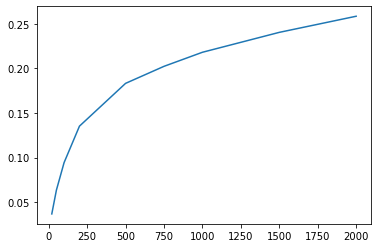

In [60]:
plt.plot(top_k_recs, own_recalls_k)
plt.show()

**Conclusion:** Of course the more sample value the more recall. But growth rate for k > 200 is low, therefore we choose number k predicts equal 200. 

In [66]:
N_PREDICT = 200

# 4. Ranking model 

### Prepare data

We need make new dataset with 'target' column

In [75]:
# get only unique users from train_ranker -- 6 weeks --
df_match_candidates = pd.DataFrame(data_train_ranker['user_id'].unique())
df_match_candidates.columns = ['user_id']

In [76]:
%%time
# get candidates from first stage (matcher)
df_match_candidates['candidates'] = df_match_candidates['user_id'].\
                                        apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.85 s, sys: 40.7 ms, total: 5.89 s
Wall time: 6.04 s


In [77]:
df_match_candidates.head(2)

,user_id,candidates
0,84,"[903529, 920025, 977374, 829722, 987518, 87304..."
1,1753,"[967041, 963686, 948640, 1057168, 9553382, 942..."


In [78]:
# get transform candidates for each user
df_items = df_match_candidates.\
                apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

# and join it
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [79]:
df_match_candidates.head(4)

,user_id,item_id
0,84,903529
0,84,920025
0,84,977374
0,84,829722


Check warm start

In [80]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates:
Shape: (438800, 2) Users: 2194 Items: 4624



### Make target column

In [102]:
# make new dataset for convenience  -- 6 weeks --
df_ranker_train = data_train_ranker[['user_id', 'item_id']].copy()
# only purchases
df_ranker_train['target'] = 1

Add zeros to dataset

In [103]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=['user_id', 'item_id'], how='left')

# clean dublicates
df_ranker_train = df_ranker_train.drop_duplicates(subset=['user_id', 'item_id'])

df_ranker_train['target'].fillna(0, inplace= True)

In [104]:
df_ranker_train.head(2)

,user_id,item_id,target
0,84,903529,1.0
2,84,920025,1.0


In [105]:
df_ranker_train.target.value_counts()

0.0    402259
1.0     21206
Name: target, dtype: int64

In [106]:
df_ranker_train['target'].mean()

0.05007733815073265

### X_train, y_train

In [107]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,84,903529,1.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,972976 PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84,920025,1.0,764,GROCERY,National,LAUNDRY ADDITIVES,FABRIC SOFTENER LIQUID,60 LOAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [109]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423465 entries, 0 to 423464
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   user_id               423465 non-null  int64 
 1   item_id               423465 non-null  int64 
 2   manufacturer          423465 non-null  int64 
 3   department            423465 non-null  object
 4   brand                 423465 non-null  object
 5   commodity_desc        423465 non-null  object
 6   sub_commodity_desc    423465 non-null  object
 7   curr_size_of_product  423465 non-null  object
 8   age_desc              153579 non-null  object
 9   marital_status_code   153579 non-null  object
 10  income_desc           153579 non-null  object
 11  homeowner_desc        153579 non-null  object
 12  hh_comp_desc          153579 non-null  object
 13  household_size_desc   153579 non-null  object
 14  kid_category_desc     153579 non-null  object
dtypes: int64(3), obje

Set category columns

In [110]:
cat_feats = X_train.columns[2:].tolist()

X_train[cat_feats] = X_train[cat_feats].fillna('Unknown')

X_train[cat_feats] = X_train[cat_feats].astype('category')

### Learn LightGBM Classifier

In [112]:
%%time
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train['target'])

train_preds = lgb.predict_proba(X_train)

CPU times: user 32.6 s, sys: 401 ms, total: 33 s
Wall time: 4.48 s


Make dataset for predict and rerank

In [113]:
df_ranker_predict = df_ranker_train.copy()

In [114]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]
df_ranker_predict['proba_item_purchase'][:5]

0    0.184648
1    0.090164
2    0.076059
3    0.067189
4    0.005938
Name: proba_item_purchase, dtype: float64

### Evaluate on test data

Make dataset for evaluate ranker model

In [115]:
result_eval_ranker = data_val_ranker.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker.columns=['user_id', 'actual']
result_eval_ranker.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


Add own recommendations

In [116]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker['user_id'].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.36 s, sys: 442 ms, total: 5.8 s
Wall time: 5.85 s


In [117]:
# Get rerank recommendations (rerank, sort and cut top-5)
def rerank(user_id, k=5):
    return df_ranker_predict[df_ranker_predict['user_id']==user_id].\
                sort_values('proba_item_purchase', ascending=False).head(k).item_id.tolist()

Add rerunk own recommendations

In [118]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker['user_id'].apply(lambda user_id: rerank(user_id))

In [123]:
result_eval_ranker.head(3)

,user_id,actual,own_rec,reranked_own_rec
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[8293439, 13877012, 1041796, 1135834, 15926844]"
1,2,"[820165, 820291, 826784, 826835, 829009, 85784...","[1103898, 911974, 1076580, 5567582, 1056620, 9...","[898847, 885023, 1029743, 945901, 916122]"
2,3,"[827683, 908531, 989069, 1071377, 1080155, 109...","[1092937, 1008714, 12132312, 1075979, 998206, ...","[1029743, 6534035, 916122, 992529, 904777]"


In [121]:
TOPK_PRECISION = 5

In [122]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1260364842454387)
('own_rec', 0.12586298459904327)


So far a mediocre result

### Learn CatBoost

In [124]:
%%time

model = CatBoost(params ={'objective': "Logloss",
                          "iterations":1000,  # n_estimators
                          "max_depth":8,
                        })

model.fit(X_train, y_train, silent=True, cat_features=cat_feats)

train_preds = model.predict(X_train, prediction_type="Probability")

CPU times: user 37min 25s, sys: 25.2 s, total: 37min 50s
Wall time: 5min 38s


In [125]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [126]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker['user_id'].apply(lambda user_id: rerank(user_id))

In [127]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1297954671088991)
('own_rec', 0.12586298459904327)


**Conclusion:** CatBoost shows best result but it is still so far a mediocre

# 5. Feature engineering for ranking

### Prepare data

For best ranking result we need take raw data without prefilter function

In [501]:
# take raw data_train_matcher without prefilter
data_train_matcher_feats = data[data['week_no'] < data['week_no'].max() - VAL_MATCHER_WEEKS]

# but still exclude cold-start
data_train_matcher_feats = data_train_matcher_feats[data_train_matcher_feats.user_id.isin(common_users)]

data_val_matcher already has raw data

In [502]:
# make joined dataset from 1-st layer (matching)  -- old weeks + 6 weeks --
df_join_train_matcher = pd.concat([data_train_matcher_feats, data_val_matcher])

In [503]:
df_join_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [554]:
# Get new feature 
def get_feature(group_by, agg_col, agg_func, denominator_flag=False, denominator_num='week_no'):
    # base value of denominator
    denominator = 1
    
    # if flag == true then calculate number of unique value for denominator
    if denominator_flag:
        denominator = df_join_train_matcher[denominator_num].nunique()
    
    # return new column as Series 
    return X_train.merge(df_join_train_matcher.groupby(by=group_by)[agg_col].agg(agg_func)\
                         .rename('new_feature')/denominator, 
                         how='left', 
                         on=group_by).iloc[:, -1].fillna(0)

### Add Item features

In [532]:
# X_train = X_train.drop(columns=X_train.columns[15:].tolist())

In [522]:
X_train['total_item_sales_value'] = get_feature('item_id', 'sales_value', 'sum')

X_train['total_quantity_value'] = get_feature('item_id', 'quantity', 'sum')

X_train['item_freq'] = get_feature('item_id', 'user_id', 'count')

X_train['item_quantity_per_week'] = get_feature('item_id', 'quantity', 'sum', True, 'week_no')

X_train['item_quantity_per_basket'] = get_feature('item_id', 'quantity', 'sum', True, 'basket_id')

X_train['item_freq_per_basket'] = get_feature('item_id', 'user_id', 'count', True, 'basket_id')

### Add User features

In [523]:
X_train['user_freq'] = get_feature('user_id', 'user_id', 'count')

X_train['total_user_sales_value'] = get_feature('user_id', 'sales_value', 'sum')

X_train['user_quantity_per_week'] = get_feature('user_id', 'quantity', 'sum', True, 'week_no')

X_train['user_quantity_per_baskter'] = get_feature('user_id', 'quantity', 'sum', True, 'basket_id')

X_train['user_freq_per_basket'] = get_feature('user_id', 'user_id', 'count', True, 'basket_id')

### Add paired User-Item features

In [555]:
X_train['user_item_total_sales'] = get_feature(['user_id', 'item_id'], 'sales_value', 'sum')

X_train['user_item_total_quantity'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum')

X_train['user_item_freq'] = get_feature(['user_id', 'item_id'], 'user_id', 'count')

X_train['user_item_quantity_per_week'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum', True, 'week_no')

X_train['user_item_quantity_per_baskter'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum', True, 'basket_id')

In [556]:
X_train.iloc[:, 15:].head(2)

,total_item_sales_value,total_quantity_value,item_freq,item_quantity_per_week,item_quantity_per_basket,item_freq_per_basket,user_freq,total_user_sales_value,user_quantity_per_week,user_quantity_per_baskter,user_freq_per_basket,user_item_total_sales,user_item_total_quantity,user_item_freq,user_item_quantity_per_week,user_item_quantity_per_baskter
0,243.93,72.0,51.0,0.757895,0.000280,0.000198,439.0,1153.65,91.294737,0.033749,0.001708,37.64,11.0,11.0,0.115789,0.000043
1,449.74,81.0,78.0,0.852632,0.000315,0.000304,439.0,1153.65,91.294737,0.033749,0.001708,39.93,7.0,7.0,0.073684,0.000027


### Evaluate CatBoost

In [558]:
%%time

model.fit(X_train, y_train, silent=True, cat_features=cat_feats)

train_preds = model.predict(X_train, prediction_type="Probability")

CPU times: user 40min 3s, sys: 35.8 s, total: 40min 38s
Wall time: 6min 3s


In [559]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

result_eval_ranker['reranked_own_rec'] = result_eval_ranker['user_id'].apply(lambda user_id: rerank(user_id))

In [550]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.27252625760088234)
('own_rec', 0.12586298459904327)


In [578]:
print(f'Relative growth is {round((0.27252625760088234 - 0.12586298459904327) / 0.12586298459904327 * 100, 1)} %')

Relative growth is 116.5 %
